In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

In [2]:
df = pd.read_fwf("interexp.dat")
df.head()

,yA,yB
0,25.33,26.45
1,26.77,27.53
2,22.76,20.02
3,20.94,22.83
4,25.40,28.05


In [3]:
def impute_B(B_mean, yA, A_mean, B_var, A_var, rho):
    return B_mean + (yA - A_mean) * np.sqrt(B_var/A_var) * rho

def impute_A(A_mean, yB, B_mean, A_var, B_var, rho):
    return A_mean + (yB - B_mean) * np.sqrt(A_var/B_var) * rho

In [4]:
θA, θB = df.yA.mean(), df.yB.mean()
σ2A, σ2B = df.yA.var(), df.yB.var()
ρ = df.corr().iloc[0,1]

imputed_df = []
for _, (yA, yB) in df.iterrows():
    if np.isnan(yA):
        imputed_df.append((impute_A(θA, yB, θB, σ2A, σ2B, ρ), yB))
    elif np.isnan(yB):
        imputed_df.append((yA, impute_B(θB, yA, θA, σ2B, σ2A, ρ)))
    else:
        imputed_df.append((yA, yB))

imputed_df = pd.DataFrame(imputed_df, columns=df.columns)

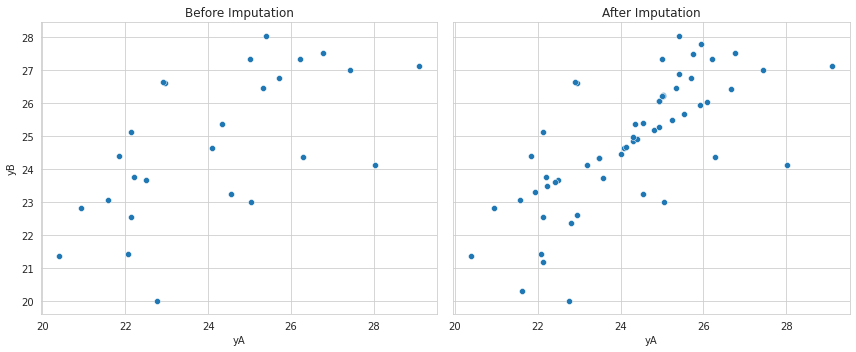

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.scatterplot(data=df, x='yA', y='yB', ax=ax[0])
sns.scatterplot(data=imputed_df, x='yA', y='yB', ax=ax[1])

ax[0].set_title("Before Imputation")
ax[1].set_title("After Imputation")

fig.tight_layout()
fig.show()

In [6]:
stats.ttest_rel(imputed_df.yA, imputed_df.yB)

Ttest_relResult(statistic=-3.2807095154382924, pvalue=0.001769777210419715)

In [36]:
dof = imputed_df.shape[0] - 1
mean = (imputed_df.yA - imputed_df.yB).mean()
sd = (imputed_df.yA - imputed_df.yB).std()
t_ci = np.array(stats.t.interval(0.95, df=imputed_df.shape[0]-1))
ci = mean + t_ci * (sd/np.sqrt(imputed_df.shape[0]))
ci

array([-0.98507303, -0.23833467])

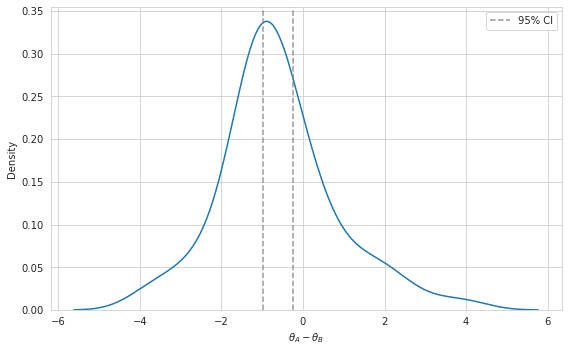

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(imputed_df.yA - imputed_df.yB, ax=ax)
ax.set_xlabel("$\\theta_A - \\theta_B$")
ax.axvline(ci[0], color='grey', linestyle='--', alpha=0.8, label='95% CI')
ax.axvline(ci[1], color='grey', linestyle='--', alpha=0.8)

ax.legend()
fig.tight_layout()
fig.show()

### (C) Gibbs Sampling

In [98]:
from numpy.linalg import inv
from numpy.random import multivariate_normal
from scipy.stats import invwishart

class MVNMean:
    def __init__(self, μ0, Σ0):
        self.μ0 = μ0
        self.Σ0 = Σ0
        self.Λ0 = inv(Σ0)
    
    def sample_prior(self, size=1):
        return multivariate_normal(self.μ0, self.Σ0, size=size)
    
    def sample_posterior(self, X, Σ, size=1):
        n = X.shape[0]
        X_mean = X.mean(axis=0)

        Λ = inv(Σ)
        Λn = self.Λ0 + n * Λ
        Σn = inv(Λn)
        μn = Σn @ (Λ @ (n*X_mean) + self.Λ0 @ self.μ0)
        return multivariate_normal(μn, Σn, size=size)

class MVNSigma:
    def __init__(self, ν0, S0):
        self.ν0 = ν0
        self.S0 = S0
    
    def sample_prior(self, size=1):
        return invwishart(self.ν0, self.S0).rvs(size=size)
    
    def sample_posterior(self, X, θ, size=1):
        n = X.shape[0]
        S = (X - θ).T @ (X - θ)

        νn = self.ν0 + n
        Sn = self.S0 + S
        return invwishart(νn, Sn).rvs(size=size)

def impute_B(B_mean, yA, A_mean, B_var, A_var, rho):
    return B_mean + (yA - A_mean) * np.sqrt(B_var/A_var) * rho

def impute_A(A_mean, yB, B_mean, A_var, B_var, rho):
    return A_mean + (yB - B_mean) * np.sqrt(A_var/B_var) * rho

def cov2corr(Σ):
    var = np.diag(Σ).reshape(-1, 1)
    return Σ / np.sqrt(var @ var.T)

def impute_X(X, θ, Σ):
    θA, θB = θ
    σ2A, σ2B = Σ[0,0], Σ[1,1]
    ρ = cov2corr(Σ)[0,1]

    imputed_X = []
    for (yA, yB) in X:
        if np.isnan(yA):
            imputed_X.append((impute_A(θA, yB, θB, σ2A, σ2B, ρ), yB))
        elif np.isnan(yB):
            imputed_X.append((yA, impute_B(θB, yA, θA, σ2B, σ2A, ρ)))
        else:
            imputed_X.append((yA, yB))

    return np.array(imputed_X)
    

In [96]:
# get data
df = pd.read_fwf("interexp.dat")
X = df.values
N = df.shape[0]

# prior parameters
θ_rv = MVNMean(
    μ0 = df.mean().values,
    Σ0 = df.dropna().cov().values
)

Σ_rv = MVNSigma(
    ν0 = 2,
    S0 = df.dropna().cov().values
)

samples = []
nEpochs = 10000
Σ = Σ_rv.sample_prior()
θ = θ_rv.sample_prior().ravel()
imputed_X = impute_X(X, θ, Σ)
for epoch in range(nEpochs):
    θ = θ_rv.sample_posterior(imputed_X, Σ).ravel()
    Σ = Σ_rv.sample_posterior(imputed_X, θ)
    imputed_X = impute_X(X, θ, Σ)

    diff = θ[0] - θ[1]

    samples.append((θ, Σ, diff))

Mean = -0.6147371019225895
95% CI = [-1.01590576 -0.2070821 ]


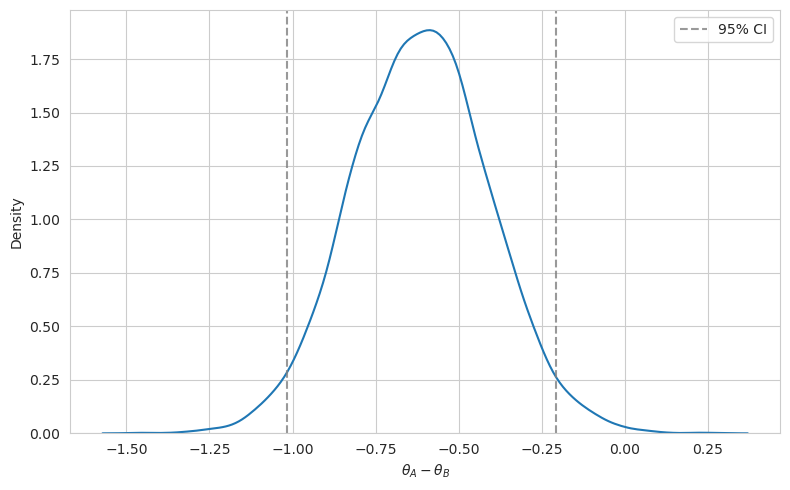

In [97]:
fig, ax = plt.subplots(figsize=(8, 5))

sr = pd.DataFrame(map(lambda x: x[2], samples))
ci = sr[0].quantile([0.025, 0.975]).values
mean = sr[0].mean()

sns.kdeplot(data=sr, x=0, ax=ax)
ax.set_xlabel("$\\theta_A - \\theta_B$")
ax.axvline(ci[0], color='grey', linestyle='--', alpha=0.8, label='95% CI')
ax.axvline(ci[1], color='grey', linestyle='--', alpha=0.8)

ax.legend()
fig.tight_layout()
fig.show()

print(f"Mean = {mean}")
print(f"95% CI = {ci}")